1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("./data.csv")

In [4]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)

In [6]:
df.loc[df["treatment"] != "No Offer", "treatment"] = 1
df.loc[df["treatment"] == "No Offer", "treatment"] = 0

In [7]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, :"treatment"], df["target"], test_size=0.3, random_state=42)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [9]:
# в принципе из всего инжениринга тут интересны только две фичи "recency" и "history" по логике чем меньше срок от даты 
# последней покупки, тем больше вероятность что пользователь совершил больше покупок и соответсвенно это тоже может как-то влиять
# на историю взаимодейтсвия поэтому надо попробовать посмотреть распределение в разрезе месяцев с даты последней покупки
# остальным фичам достаточно будет сделать dummy переменные, этого думаю будет достаточно

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"

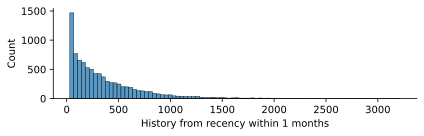

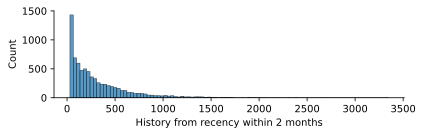

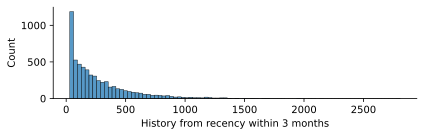

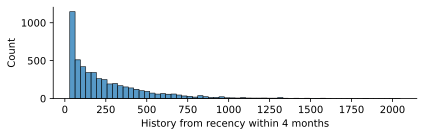

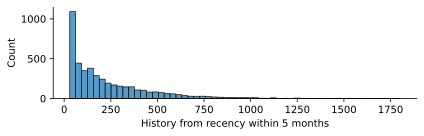

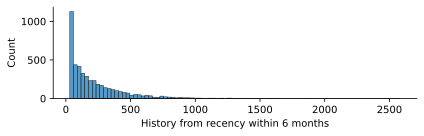

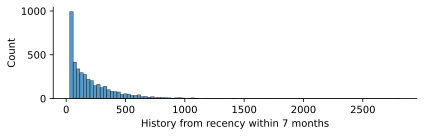

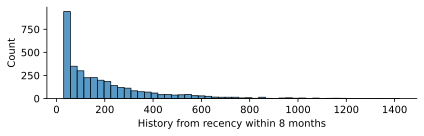

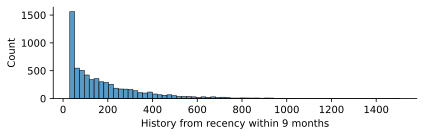

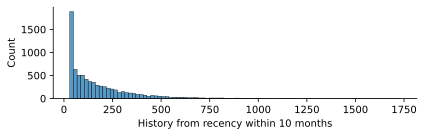

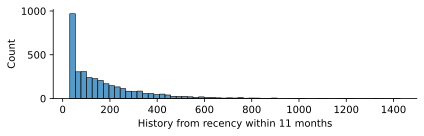

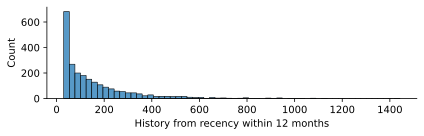

In [11]:
for i in range(1, 13):
    sns.displot(df.loc[df["recency"] == i, "history"], height=2, aspect=3)
    plt.xlabel(f"History from recency within {i} months")

In [12]:
# собственно по распределению видно что в основном оно по форме одинаково и большинство значений все равно лежит в промежутке
# от 0 до 200 но видно так же как распрделеены хвосты. Наспример за первый квартал хвост доходит до 1500, за 2 квааратал до 1000
# ну и за 3 и 4 кваратал хвосты имеют все меньше оценки разброса
# можно посотреть на распределение среднего и медианы. И можно будет оценить насколько их разница с каждым месяцем уменьшается

In [13]:
for i in range(1, 13):
    med = df.loc[df["recency"] == i, "history"].median()
    avg = df.loc[df["recency"] == i, "history"].mean()
    print(f"For {i} months median={med:,.2f} and average ={avg:,.2f} with diff_between={med-avg:,.2f}")

For 1 months median=252.96 and average =359.84 with diff_between=-106.88
For 2 months median=211.39 and average =310.99 with diff_between=-99.60
For 3 months median=187.49 and average =274.46 with diff_between=-86.98
For 4 months median=172.22 and average =251.31 with diff_between=-79.09
For 5 months median=155.87 and average =233.15 with diff_between=-77.29
For 6 months median=145.72 and average =218.39 with diff_between=-72.67
For 7 months median=143.44 and average =207.56 with diff_between=-64.12
For 8 months median=132.92 and average =194.92 with diff_between=-62.00
For 9 months median=128.14 and average =185.87 with diff_between=-57.73
For 10 months median=116.91 and average =172.10 with diff_between=-55.19
For 11 months median=118.47 and average =168.02 with diff_between=-49.55
For 12 months median=101.85 and average =153.98 with diff_between=-52.13


In [14]:
# поэтому предлагаю преобразовать фичу "recency" в бинарную с логикой 1 - была активность последний квартал, 
# 0 - не было активности в последний квартал

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [16]:
# делаем трансформер колонок, категориальные преобразуем с помощью OneHot, непрерывную с помощью Standart 
# и пишем дополнительный класс для преобразования recency 

In [17]:
X_treat = X_train.iloc[:, -1]
X_train = X_train.iloc[:, :-1]

In [18]:
X_treat_test = X_test.iloc[:, -1]
X_test = X_test.iloc[:, :-1]

In [19]:
class RecencyPrep(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.key = "recency"

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[X[self.key] < 4] = 1
        X[X[self.key] >= 4] = 0
        return X

In [20]:
class ToIntTransf(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        X[0] = X[0].astype(int, copy=False)
        X[2] = X[2].astype(int, copy=False)
        X[3] = X[3].astype(int, copy=False)
        X[4] = X[4].astype(int, copy=False)
        X[5] = X[5].astype(int, copy=False)
        X[6] = X[6].astype(int, copy=False)
        X[7] = X[7].astype(int, copy=False)
        X[8] = X[8].astype(int, copy=False)
        X[9] = X[9].astype(int, copy=False)
        X[10] = X[10].astype(int, copy=False)
        return X

In [21]:
col_trans = make_column_transformer(
                                    (RecencyPrep(), ["recency"]),
                                    (StandardScaler(), ["history"]),
                                    (OneHotEncoder(), ["zip_code", "channel"]), remainder="passthrough"
                                    )

In [22]:
final_pipe = make_pipeline(col_trans, ToIntTransf())

In [23]:
final_pipe.fit(X_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('recencyprep', RecencyPrep(),
                                                  ['recency']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['history']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['zip_code', 'channel'])])),
                ('tointtransf', ToIntTransf())])

In [24]:
from sklift.metrics import uplift_at_k
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [25]:
sm = SoloModel(CatBoostClassifier(iterations=100, depth=7, random_state=42, silent=True, loss_function="CrossEntropy"))

In [26]:
sm = sm.fit(final_pipe.transform(X_train), y_train, X_treat, 
            estimator_fit_params={'cat_features': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [27]:
uplift_sm = sm.predict(final_pipe.transform(X_test))
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_treat_test, strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_treat_test, strategy='by_group', k=0.1)

In [28]:
model_results = {}
model_results["SoloModel"] = [sm_score_10, sm_score_20]

In [29]:
from sklift.models import ClassTransformation

In [30]:
ct = ClassTransformation(CatBoostClassifier(iterations=100, depth=7, random_state=42, 
                                            silent=True, loss_function="CrossEntropy"))
ct = ct.fit(final_pipe.transform(X_train), y_train, X_treat, 
            estimator_fit_params={'cat_features': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

c:\users\shelpov.a\anaconda3\envs\causalml\lib\site-packages\ipykernel_launcher.py:4: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  after removing the cwd from sys.path.


In [31]:
uplift_ct = ct.predict(final_pipe.transform(X_test))
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_treat_test, strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_treat_test, strategy='by_group', k=0.1)

In [32]:
model_results["TransformClass"] = [ct_score_10, ct_score_20]

In [33]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100, depth=7, random_state=42, 
                                            silent=True, loss_function="CrossEntropy"), 
    estimator_ctrl=CatBoostClassifier(iterations=100, depth=7, random_state=42, 
                                            silent=True, loss_function="CrossEntropy"), 
    method='vanilla'
)

tm = tm.fit(
    final_pipe.transform(X_train), y_train.reset_index(drop=True), X_treat.reset_index(drop=True),
    estimator_trmnt_fit_params={'cat_features': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, 
    estimator_ctrl_fit_params={'cat_features': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
)


In [34]:
uplift_tm = tm.predict(final_pipe.transform(X_test))
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_treat_test, strategy='by_group', k=0.2)
tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_treat_test, strategy='by_group', k=0.1)

In [35]:
model_results["TwoModels"] = [tm_score_10, tm_score_20]

In [36]:
pd.DataFrame.from_dict(model_results, orient="index", columns=["upift@10%", "uplift@20%"])

,upift@10%,uplift@20%
SoloModel,0.093079,0.075492
TransformClass,0.119943,0.106623
TwoModels,0.120589,0.097922


Получил в итоге какие-то предсказания. Признаться честно до конца пока не въехал как эти модели отличаются. С точки зрения понимания самая простая соло модель....предсказываешь оценки двух классов по одному объекту и наибольшая разница является теми искомыми контрагентами с которыми надо максимально взаимодейтсвовать. Понятно чем порог ниже тем аплифт выше , но тут скорее еще вопрос затрат и выхлопа от этого аплифта.

построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [39]:
X_tree_train = X_train

In [40]:
X_tree_train.loc[X_tree_train["recency"] < 4 , "recency"] = 1
X_tree_train.loc[X_tree_train["recency"] >= 4 , "recency"] = 0

In [41]:
X_tree_train = pd.get_dummies(X_tree_train, columns=["zip_code", "channel"])

In [42]:
X_tree_train.head(2)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
9656,0,434.35,1,0,1,0,0,1,0,0,1
63037,1,376.59,1,0,0,0,1,0,1,0,0


In [43]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [84]:
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=500, min_samples_treatment=250,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_tree_train.values,
                 treatment=X_treat.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)


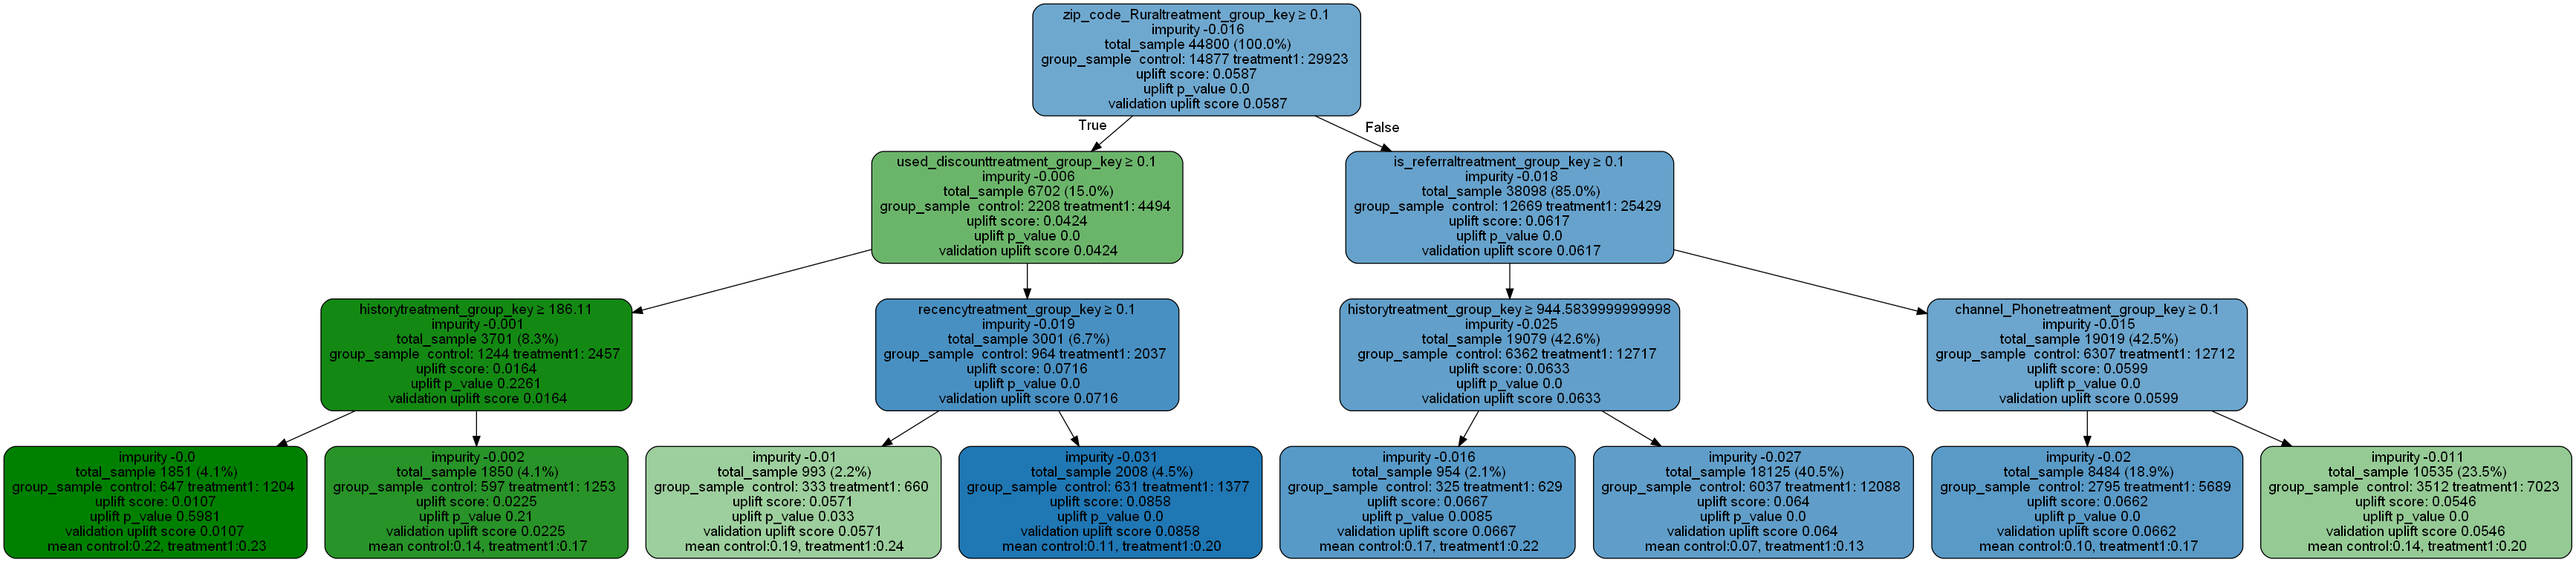

In [85]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, X_tree_train.columns)
Image(graph.create_png())

немного поэкспериментировал с параметрами, но помоему это лучше что мог найти
если смотреть н последние листья в ддереве слева направо, то первые два получаются статистически незначимыми, т.е. вероятность получить такие и еще более выраженные различия по аплифту (при условии того что верна гипотеза о равенстве распределений) для самого левого листа составляет 59%, для второго 21%....поэтому их рассматривать смысла нет.  
Дальше идут листья вправо статистики которых уже имеют определенную силу.   
Если рассматривать 3 и 4 лист слева, то аплифт по ним есть....эффективность его наверное нужно определять отдельно. На мой взгляд по этой выборке смысла разделения в предыдущем узле нет, поскольку аплифт примерно одинаковый. Сами листья бьются по признаку recent, который в свою очередь бьется по признаку used_discount, который в свою очередь бьется по признаку zip_code_Rural таким образом в этот пул попадают деревенские жители, которые не пользовались скидками и примерный аплифт по таким покупателям на уровне 7%.  
Далее смотрим на 5 и 6 лист слева тут тоже смысл последнего узла кажется лишним, поскольку аплифт примерно одинаковый и получается группа пользователей не из деревни, которые совершали покупки по выделееному то ли каналу.....не совсем понял признак referral но думаю что-то связано с каналами продаж....мб интернет-магазин или заказы по телефону.  
И последние листья описывают пользователей не из деревни, которые не покупали с определенных каналов продаж и с которыми воздействие было по телефону.....тоже смысла в последнем листе особо нет.   
Поэтому как вариант можно попробовать посторить дерево из меньшего количества узлов, скорее всего признаки будут другие, но посмотреть стоит

In [87]:
uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=500, min_samples_treatment=250,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_tree_train.values,
                 treatment=X_treat.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)


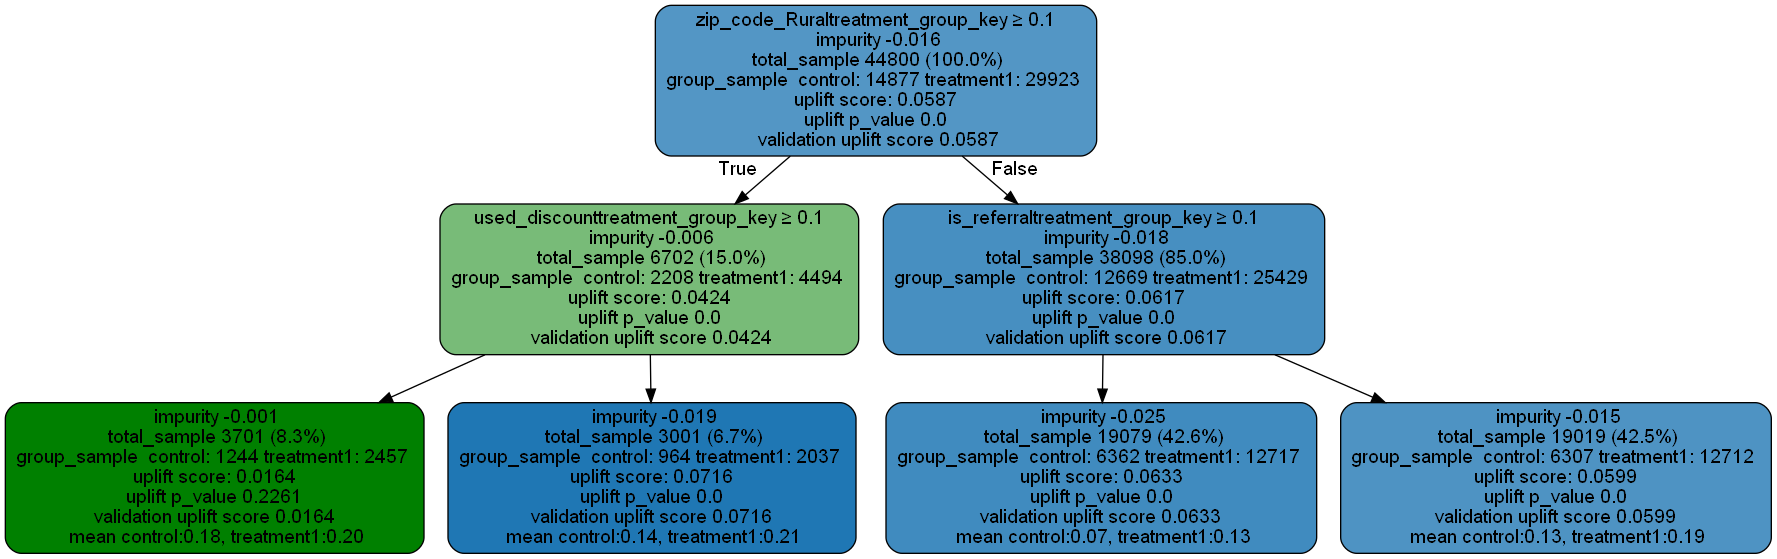

In [88]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, X_tree_train.columns)
Image(graph.create_png())

Аннн нет)) узлы все теже, только дерево обрезано на один слой листьев. Как и ранее самый левый статистически незначимый. А остальные имеют какой-то аплифт. На мой взгляд если и выбирать с кем необходимо производить взаимодействия, то это с пользователями из второго листа слева. При примерном аплифте этого листа со всеми остальными, общая популяция в данном листе на порядок меньше. Т.е. чтобы добиться аплифта в 7% нам нужно обзвонить 3000 человек......это проще чем сделать тоже самое для 19000 как в 3 и 4 листах слева....  
Конечно и в абсолютных суммах аплифт будет другой, но тут уже вопрос скорее эффективности этой компании и реального выхлопа от всей затеи.  
В общем я ставлю на ребят из второго листа слева....т.е. это деревенские жители, которые не пользовались ранее скидками